Setting up Spark

In [ ]:
!ls

sample_data


In [ ]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
## NOTE that this version would make use of Hadoop if installed BUT that HDFS & Hadoop is not installed on our Colab
## (we are only using a single node (probably as a VM) so we will not be able to benefit from parallelism)
!clear
!echo welcome

!rm -f spark-3.4.[01]-bin-hadoop3.tgz*
!rm -rf spark-3.4.[01]-bin-hadoop3

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
!tar -xf spark-3.4.3-bin-hadoop3.tgz

!ls -alt
print("standalone Spark is now installed")

welcome
--2024-05-04 17:22:21--  https://downloads.apache.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388930980 (371M) [application/x-gzip]
Saving to: ‘spark-3.4.3-bin-hadoop3.tgz’

spark-3.4.3-bin-had 100%[===================>] 370.91M  19.4MB/s    in 20s     

2024-05-04 17:22:42 (18.2 MB/s) - ‘spark-3.4.3-bin-hadoop3.tgz’ saved [388930980/388930980]

total 379840
drwxr-xr-x  1 root root      4096 May  4 17:22 .
drwxr-xr-x  1 root root      4096 May  4 17:21 ..
drwxr-xr-x  1 root root      4096 May  2 13:25 sample_data
drwxr-xr-x  4 root root      4096 May  2 13:24 .config
-rw-r--r--  1 root root 388930980 Apr 15 01:30 spark-3.4.3-bin-hadoop3.tgz
drwxr-xr-x 13 1000 1000      4096 Apr 15 01:28 spark-3.4.3-bin-hadoop3
standa

In [ ]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
!pip3 install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *
SparkSession.builder.getOrCreate()
##

In [ ]:
spark = SparkSession.builder.appName("BigDataProject2024").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

importing and installing packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, month, mean, to_date, year, to_timestamp
import shutil
from google.colab import drive
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

connecting to drive

In [ ]:
drive.mount('/content/drive/') #connecting to drive

Mounted at /content/drive/


Unpacking .zip file of .csv's

In [ ]:
shutil.unpack_archive("/content/drive/MyDrive/Big Data/cyclehireusagestats-2014.zip", "/content/Datasets/") #uzipping tfl data

Creating dataframe of all .csv files contained in 'cyclehireusagestats-2014.zip'

In [ ]:
df = spark.read.csv("/content/Datasets/*.csv", header=True) #adding all csvs to a dataframe
df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

removing null values

In [ ]:
no_nulls_df = df.dropna(how='any', thresh=None, subset=None) #creating dataframe with any rows with any null values removed
num_of_nulls = df.count() - no_nulls_df.count() #calculating how many rows contained null values
print("number of nulls: ", num_of_nulls) #printing total null containing rows

number of nulls:  1239245


changing "Start date" from string to date var

In [ ]:
no_nulls_df = no_nulls_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm"))
no_nulls_df.show()

+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|2014-07-06 16:14:00|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/

making data frame that only contains rides in 2014

In [ ]:
in_2014_df = no_nulls_df.filter(year(col("Start Date")).contains(2014))
in_2014_df.show()

+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|2014-07-06 16:14:00|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/

adding column containing month the journey started in

In [ ]:
in_2014_df = in_2014_df.withColumn("Month", month("Start Date"))
in_2014_df.show()

+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+-----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Month|
+---------+--------+-------+----------------+-------------+--------------------+-------------------+---------------+--------------------+-----+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|    6|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|    7|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|    7|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|2014-07-06 16:14:00|            311|Foley Street, Fit...

getting information for each month

In [ ]:
months = {} #initialise dictionary to store data for each month

#loops through each month, filters dataframe to that month, filters further into Aston ST and not Aston St, calculate means, store results
for i in range(1,13): #1-13 so that it starts from 1 and ends on 12, how the months are written in df

    months[i] = {} #initialise dictionary to store results for current month

    month_df = in_2014_df.filter(col("Month").contains(i)) #filter df for current month

    months[i]["total_rides"] = month_df.count() #show total rides for month (used for weighted avg)

    aston_df = month_df.filter(col("StartStation Name") == "Aston Street, Stepney")
    others_df = month_df.filter(col("StartStation Name") != "Aston Street, Stepney") #filter df for Aston Street and other stations

    aston_mean_df = aston_df.agg(mean("Duration").alias("average_duration"))#Calc mean duration for aston
    months[i]["aston_avg_duration"] = aston_mean_df.collect()[0]["average_duration"] #add to dictionary for current month

    others_means_df = others_df.groupBy("StartStation Id").agg(mean("Duration").alias("average_duration")) #groups other stations + finds mean for each
    others_means_collected = others_means_df.collect() #add means for other stations to a list
    months[i]["others_means"] = [row['average_duration'] for row in others_means_collected] # adds list of means for other stations to dictionary for current month

    others_avg_duration_df = others_df.agg(mean("Duration").alias("average_duration")) #calc mean duration from other stations (only for graph)
    months[i]["others_avg_duration"] = others_avg_duration_df.collect()[0]["average_duration"] #add to dic.

    print(i, " done")

1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done
10  done
11  done
12  done


performing one-sided t-test on each month

In [ ]:
for month in months:
  # - t test -
  #null: journey durations from other stations are greater than journey durations from Aston street
  #alternate: journeys durations from other stations are greater than from Aston (ie journeys from Aston are shorter)
  #p val threshhold: 0.05 -> if higher reject null hypothesis
    months[month]["t_stat"], months[month]["p_val"] = stats.ttest_1samp(months[month]["others_means"], months[month]["aston_avg_duration"], alternative="greater")

    print("Month: ", month) #outputting results
    print("Total rides: ", months[month]["total_rides"])
    print("Aston mean jounrey duration:", months[month]["aston_avg_duration"])
    print("Mean journey duration from other stations ", months[month]["others_avg_duration"])
    print("T stat:", months[month]["t_stat"])
    print("P val: ", months[month]["p_val"])
    print(" ")

Month:  1
Total rides:  2663265
Aston mean jounrey duration: 1116.602086438152
Mean journey duration from other stations  1321.4734568541423
T stat: 10.151156542571066
P val:  4.4452598834903317e-23
 
Month:  2
Total rides:  1089801
Aston mean jounrey duration: 929.447004608295
Mean journey duration from other stations  1350.9554031331588
T stat: 14.91994247918614
P val:  1.4013763649882424e-44
 
Month:  3
Total rides:  748458
Aston mean jounrey duration: 1004.7937131630648
Mean journey duration from other stations  1436.408578659775
T stat: 17.457244433137234
P val:  1.1464077482151003e-57
 
Month:  4
Total rides:  796415
Aston mean jounrey duration: 987.709090909091
Mean journey duration from other stations  1525.7447431411106
T stat: 20.337684429743348
P val:  1.0507611460062795e-73
 
Month:  5
Total rides:  880040
Aston mean jounrey duration: 1643.4028892455858
Mean journey duration from other stations  1572.9210374600445
T stat: 0.1751010670714906
P val:  0.43052389834085103
 
Mon

finding the weighted average p-val

In [ ]:
#calc weighted avg p value
total_rides_year = 0
p_vals_weighted = 0

for month in months:
  total_rides_year += months[month]["total_rides"] #holds total rides in the year
  p_vals_weighted += (months[month]["p_val"] * months[month]["total_rides"]) #adds up all the p values multiplied the rides for that month to add weighting

p_vals_weighted_avg = p_vals_weighted / total_rides_year #divide total p val by total rides to get weighted avg

if p_vals_weighted_avg < 0.05: #messages for whether or not Null is accepted
  print("Alternate hypothesis accepted, p value: ", p_vals_weighted_avg, " is less than 0.05 threshold")
else:
  print("Null hypothesis accepted, weighted average p value: ", p_vals_weighted_avg, " is greater than 0.05 threshold")

Null hypothesis accepted, weighted average p value:  0.08578904717860927  is greater than 0.05 threshold


plotting graph to show p values for each month showing the threshold level

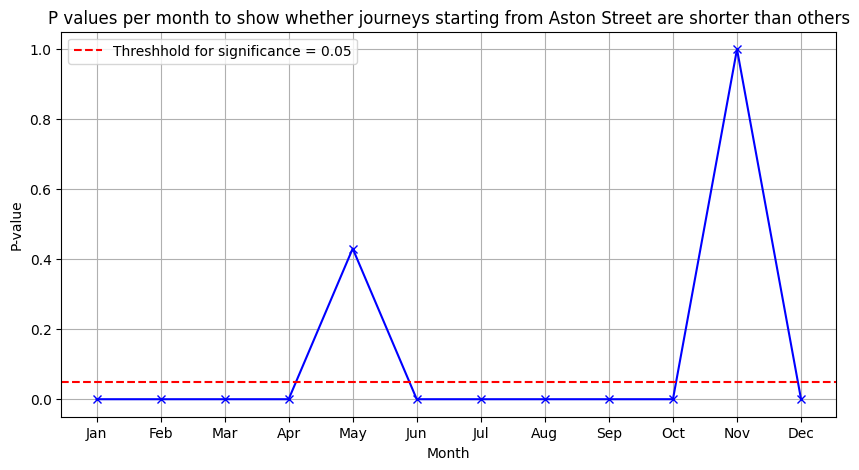

In [ ]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] #adding month names for readability

p_values = [months[i]["p_val"] for i in range(1, 13)] #getting p values from months dictionary

#creating graph
plt.figure(figsize=(10, 5))
plt.plot(month_labels, p_values, marker='x', linestyle='-', color='b') #plotting p values per month
plt.axhline(y=0.05, color='r', linestyle='--', label='Threshhold for significance = 0.05') #line to show the threshold of accepting/rejecting null hypothesis

plt.title('P values per month to show whether journeys starting from Aston Street are shorter than others')
plt.xlabel('Month')
plt.ylabel('P-value')
plt.grid(True) #aesthetics
plt.legend()
plt.show()#plot graph


graph to compare average journey durations from aston and from other stations combined

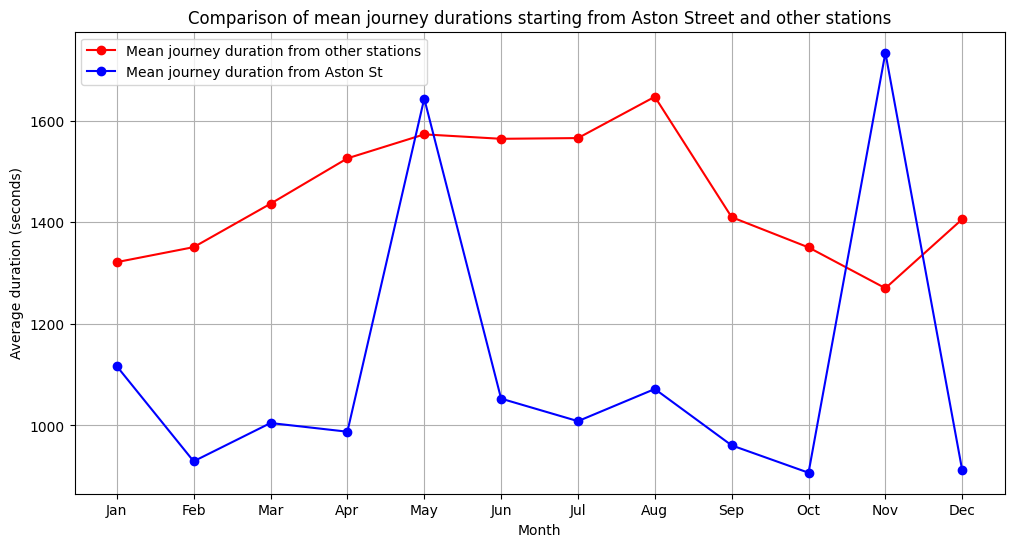

In [ ]:
others_avg_durations = [months[i]["others_avg_duration"] for i in range(1, 13)]
aston_avg_durations = [months[i]["aston_avg_duration"] for i in range(1, 13)] #getting mean durations from month dictionary

plt.figure(figsize=(12, 6)) #creating graph

plt.plot(month_labels, others_avg_durations, label='Mean journey duration from other stations', color='Red', marker='o') #plotting for others
plt.plot(month_labels, aston_avg_durations, label='Mean journey duration from Aston St', color='blue', marker='o') #plotting for Aston

plt.title('Comparison of mean journey durations starting from Aston Street and other stations')
plt.xlabel('Month')
plt.ylabel('Average duration (seconds)')
plt.grid(True)
plt.legend() #aesthetics
plt.show() #plot graph
